In [18]:
import os
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random as rnd
rnd.seed(21)

from matplotlib import rcParams
rcParams['figure.figsize'] = (20.0, 10.0)

# dataset IO

In [3]:
SINTEL_BASE_DIR = '/Users/akshitjain/ext/workspace/datasets/sintel/training'
l_path = SINTEL_BASE_DIR+'/clean_left'
r_path = 'clean_right'
d_path = 'disparities'

In [13]:
# lets get metadata first
l_path = Path(l_path)
scene_dirs = list(l_path.glob('[!.]*'))
scene_names = [p.stem for p in scene_dirs]
frames = []
for scene_dir, scene_name in zip(scene_dirs, scene_names):
    frame_paths = list(scene_dir.glob('[!.]*.png'))
    frame_names = [p.stem for p in frame_paths]
    frames.extend(['{}/{}'.format(scene_name, fname) for fname in frame_names])

In [69]:
def scene_frames_to_path(sintel_base_dir,view_sub_dir, frame_names):
    return Path('{}/{}/{}.png'.format(sintel_base_dir, view_sub_dir, fname))

sintel_dataset =[]
for fname in frames:
    entry = {
        'frame_name': fname,
        'left_view': scene_frames_to_path(SINTEL_BASE_DIR, 'clean_left', fname),
        'right_view': scene_frames_to_path(SINTEL_BASE_DIR, 'clean_right', fname),
        'depth': scene_frames_to_path(SINTEL_BASE_DIR, 'disparities', fname),
        'occlusions' : scene_frames_to_path(SINTEL_BASE_DIR, 'occlusions', fname)
    }
    sintel_dataset.append(entry)
print(sintel_dataset[:2])

[{'frame_name': 'alley_1/frame_0028', 'left_view': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/clean_left/alley_1/frame_0028.png'), 'right_view': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/clean_right/alley_1/frame_0028.png'), 'depth': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/disparities/alley_1/frame_0028.png'), 'occlusions': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/occlusions/alley_1/frame_0028.png')}, {'frame_name': 'alley_1/frame_0021', 'left_view': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/clean_left/alley_1/frame_0021.png'), 'right_view': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/clean_right/alley_1/frame_0021.png'), 'depth': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/disparities/alley_1/frame_0021.png'), 'occlusions': PosixPath('/Users/akshitjain/ext/workspace/datasets/sintel/training/occlusions/alley_

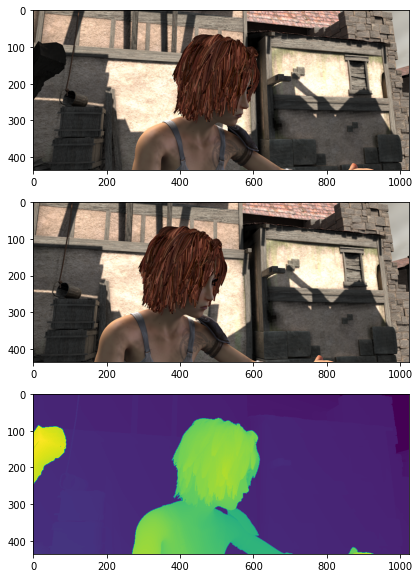

In [91]:
def read_image(path):
    return cv.cvtColor(cv.imread(str(path)), cv.COLOR_BGR2RGB)

def read_depth(filename):
    f_in = np.array(Image.open(filename))
    d_r = f_in[:,:,0].astype('float64')
    d_g = f_in[:,:,1].astype('float64')
    d_b = f_in[:,:,2].astype('float64')

    depth = d_r * 4 + d_g / (2**6) + d_b / (2**14)
    return depth

def read_mask(path):
    im=cv.imread(str(e['occlusions']), cv.IMREAD_UNCHANGED)
    mask = im>100
    return mask

for e in sintel_dataset:
    l_im = read_image(e['left_view'])
    r_im = read_image(e['right_view'])
    d_im = read_depth(e['depth'])
    o_mask = read_mask(e['occlusions'])
    _, ax = plt.subplots(3,1)
    ax[0].imshow(l_im)
    ax[1].imshow(r_im)
    ax[2].imshow(d_im)
    break
    

In [76]:
e = sintel_dataset[0]
im=cv.imread(str(e['occlusions']), cv.IMREAD_UNCHANGED)

In [81]:
# # plt.imshow(im)
# im.shape
# _=plt.hist(im.flatten())
mask = im>100
# plt.imshow(im)

In [84]:
np.sum(mask)

40037

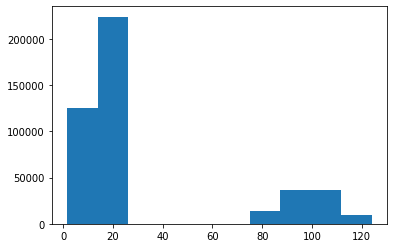

In [40]:
_=plt.hist(d_im.flatten())

# dataset stats

In [87]:
print('total train egs: {}'.format(len(sintel_dataset)))

# assert same shape on random sample
ds_shape=None
for e in rnd.sample(sintel_dataset,10):
    l_im = read_image(e['left_view'])
    r_im = read_image(e['right_view'])
    d_im = read_depth(e['depth'])
    print(d_im.min(), d_im.max())
    assert(l_im.shape == r_im.shape)
    if ds_shape is None:
        ds_shape = l_im.shape
        print('dataset shape is: {}'.format(ds_shape))
    else:
        assert(l_im.shape==ds_shape)
print('random sample has consistent shape')

total train egs: 1064
1.59375 123.96875
dataset shape is: (436, 1024, 3)
random sample has consistent shape



# assert warp 

In [58]:
import tensorflow as tf
import tensorflow_addons as tfa

In [97]:
# feats, disps_true = batch[0]
l_img = l_im
r_img = r_im
disp_true = d_im

r_im_sparse = tf.expand_dims(tf.constant(r_img, dtype=tf.float32), axis=0)
disp_x = tf.constant(disp_true, dtype=tf.float32)
disp_y = tf.zeros_like(disp_x)
flow = tf.expand_dims(tf.stack([disp_y, disp_x], axis=-1), axis=0)
im_warped = tfa.image.dense_image_warp(r_im_sparse, flow)
im_l_rec = im_warped.numpy().astype(np.uint8)[0]
im_l_rec[o_mask] = 0

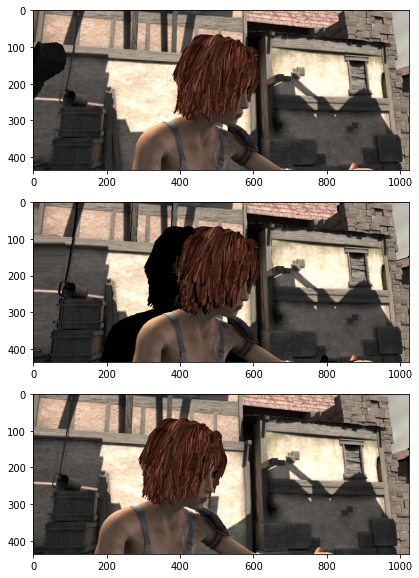

In [98]:
_, ax = plt.subplots(3,1)
ax[0].imshow(l_im)
ax[1].imshow(im_l_rec)
ax[2].imshow(r_im)

# assert tf dataset

In [3]:
%cd ..

/Volumes/ext_thumb/repos/PWC_Net_tf


In [4]:
from sintel_dataset import get_sintel_disparity_dataset, get_sintel_path
from model import nearest_multiple, pyramid_compatible_shape

In [5]:
NUM_PYRAMID_LEVELS = 8
PREDICT_LEVEL = 2
DATASET_SHAPE = (436, 1024) # h, w
MODEL_IN_SHAPE = pyramid_compatible_shape(DATASET_SHAPE, NUM_PYRAMID_LEVELS)

In [6]:
colab_env=False
sintel_tfrecord_path = get_sintel_path(colab_env)
ds = get_sintel_disparity_dataset(sintel_tfrecord_path, 1, MODEL_IN_SHAPE, NUM_PYRAMID_LEVELS)

model input shape:  (512, 1024)
left_view
right_view
depth


In [15]:
e = list(ds.take(1).as_numpy_iterator())[0]
fts, disp = e

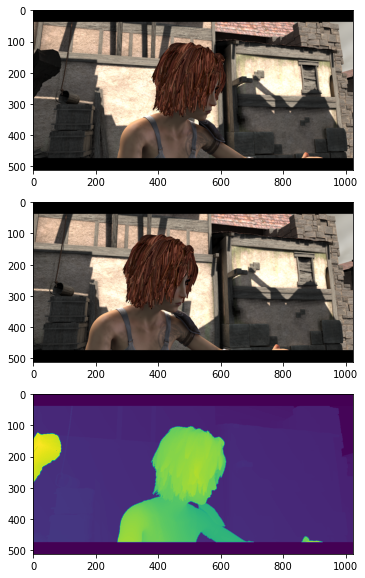

In [24]:
l_im = fts['left_view'][0]
r_im = fts['right_view'][0]
d_im = disp['l0'][0]
_, ax = plt.subplots(3,1)
ax[0].imshow(l_im)
ax[1].imshow(r_im)
ax[2].imshow(d_im)

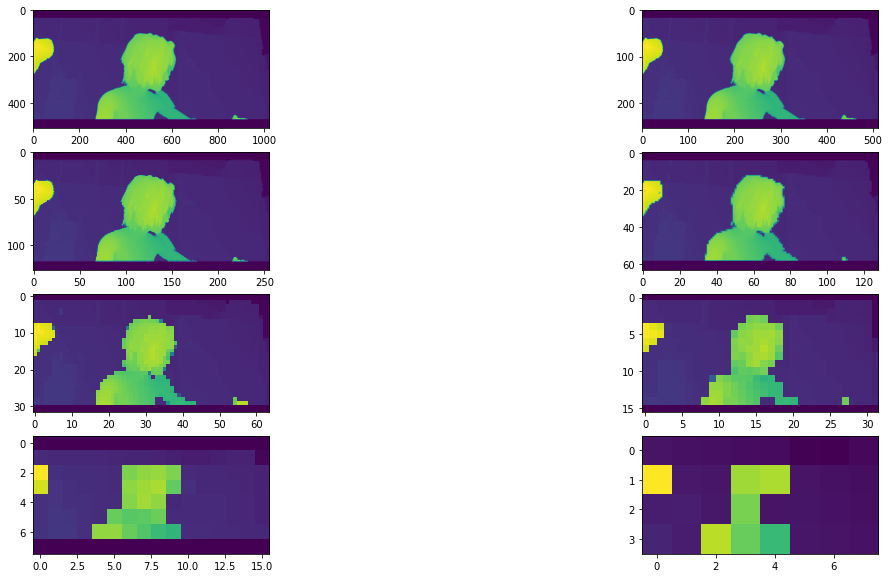

In [33]:
_, ax = plt.subplots(4,2)
for l in range(8):
    ax[np.unravel_index(l, ax.shape)].imshow(disp['l{}'.format(l)][0])

In [6]:
import random
random.seed(10)

In [13]:
foo=[x for x in range(10)]
random.Random(10).shuffle(foo)
print(foo)

[5, 2, 7, 1, 8, 4, 3, 6, 0, 9]
